- coisas para add 
    - data augmentation DONE 
    - matriz de confusao  DONE 
    - acuracia ao longo do tempo DONE 
    - nova ativacao(leaky relu) DONE 
    - tamanho dos modelos e arquiteura final  DONE 

    - CNN

# Imports

In [94]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import optuna 

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn import metrics

import seaborn as sns

from torchinfo import summary

# Helper functions and MLP class

In [66]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, activation_function, dropout_rate, use_batch_norm=True):
        super(MLP, self).__init__()
        self.activation_function = activation_function
        self.dropout = nn.Dropout(p=dropout_rate)
        self.use_batch_norm = use_batch_norm

        layers_dims = [input_size] + hidden_layers + [num_classes]
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(len(layers_dims) - 1):  
            self.layers.append(nn.Linear(layers_dims[i], layers_dims[i+1]))
            
            if use_batch_norm and i < len(layers_dims) - 2:
                self.batch_norms.append(nn.BatchNorm1d(layers_dims[i+1]))



    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_function(layer(x))
            x = self.dropout(x)

        x = self.layers[-1](x)
        
        return x 

In [67]:
def get_scores(targets, predictions):
    return {
        "accuracy"         : metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted"),
        "precision"        : metrics.precision_score(targets, predictions, average="weighted"),
        "recall"           : metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted")
    }

def evaluate_model(model, data_loader, loss_function):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def evaluate_accuracy(model, data_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    return correct / total

def show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val):
    plt.plot(arr_losses_train, label = "train loss")
    plt.plot(arr_losses_val, label = "val loss")
    plt.plot(arr_losses_test, label = "test loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    return None

def show_accuracy_through_epochs(arr_acc_train, arr_acc_test, arr_acc_val):
    plt.plot(arr_acc_train, label = "train accuracy")
    plt.plot(arr_acc_val, label = "val accuracy")
    plt.plot(arr_acc_test, label = "test accuracy")
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.grid()
    plt.legend()
    return None

def show_predictions(model, dataloader, num_samples):
    model.eval()
    correct_samples = []
    wrong_samples = []

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    with torch.no_grad():
        for images, labels in dataloader:
            original_images = images

            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()

            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(labels)):
                pred = predicted[i].cpu().item()
                true = labels[i].cpu().item()
                img = original_images[i]

                if pred == true and len(correct_samples) < num_samples:
                    correct_samples.append((img, pred, true))
                elif pred != true and len(wrong_samples) < num_samples:
                    wrong_samples.append((img, pred, true))

                if len(correct_samples) >= num_samples and len(wrong_samples) >= num_samples:
                    break

    plt.figure(figsize=(24, 20))
    
    plt.subplot(1, 2, 1)
    # acertos
    for idx, (img, pred, true) in enumerate(correct_samples):
        plt.subplot(2, num_samples, idx + 1)
        img = img.permute(1, 2, 0)  
        img = img * 0.5 + 0.5 
        plt.imshow(img)
        plt.title(f'Correto!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')

    # erros
    for idx, (img, pred, true) in enumerate(wrong_samples):
        plt.subplot(2, num_samples, idx + num_samples + 1)
        img = img.permute(1, 2, 0)
        img = img * 0.5 + 0.5
        plt.imshow(img)
        plt.title(f'Erro!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')
    
    plt.tight_layout(h_pad=2)
    plt.show()

    return None

def objective(trial):
    global train_dataset_global, validation_dataset_global

    activation_name = trial.suggest_categorical('activation', ['ReLU', 'Sigmoid', 'Tanh', 'LeakyReLU'])
    activation_functions = {
        'ReLU': nn.ReLU(),
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh(),
        'LeakyReLU' : nn.LeakyReLU()
    }
    activation_function = activation_functions[activation_name]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 512)

    # reg params
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])

    n_layers = trial.suggest_int('n_layers', 2, 7)
    hidden_layers = []
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 32, 256)
        hidden_layers.append(n_units)

    input_size = 32*32*3
    num_classes = 10
    loss_function = nn.CrossEntropyLoss()
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset_global, 
        batch_size=batch_size, 
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=validation_dataset_global, 
        batch_size=batch_size, 
        shuffle=False
    )

    model = MLP(
        input_size=input_size,
        hidden_layers=hidden_layers,
        num_classes=num_classes,
        activation_function=activation_function,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm
    ).cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    for _ in range(50):
        model.train()
        for images, labels in train_loader:
            images = images.view(-1, input_size).cuda()
            labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval() # disable dropout just to validate
        val_loss = evaluate_model(model, val_loader, loss_function)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
    
    return best_val_loss


# Setup

In [68]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

validation_dataset.dataset.transform = transform_test

In [69]:
# just to run fast
subset_sample      = 1000

train_dataset      = torch.utils.data.Subset(train_dataset, range(subset_sample))
validation_dataset = torch.utils.data.Subset(validation_dataset, range(subset_sample))
test_dataset       = torch.utils.data.Subset(test_dataset, range(subset_sample))


In [70]:
train_dataset_global = train_dataset
validation_dataset_global = validation_dataset

# Def hyperparameters and Loaders

In [71]:
loss_function       = nn.CrossEntropyLoss()

# Main training Loop

## Optuna optimization

In [72]:
n_trials=1
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

[I 2025-06-14 21:08:56,368] A new study created in memory with name: no-name-80849d2b-2754-4dac-8115-df48b9e3b1e6
[I 2025-06-14 21:08:58,079] Trial 0 finished with value: 1.9532281387419927 and parameters: {'activation': 'ReLU', 'learning_rate': 0.0021692155227881573, 'batch_size': 48, 'dropout_rate': 0.24490906733875856, 'weight_decay': 0.0019507758396502184, 'use_batch_norm': False, 'n_layers': 2, 'n_units_l0': 75, 'n_units_l1': 91}. Best is trial 0 with value: 1.9532281387419927.


## Best founded model

In [73]:
study.best_params

{'activation': 'ReLU',
 'learning_rate': 0.0021692155227881573,
 'batch_size': 48,
 'dropout_rate': 0.24490906733875856,
 'weight_decay': 0.0019507758396502184,
 'use_batch_norm': False,
 'n_layers': 2,
 'n_units_l0': 75,
 'n_units_l1': 91}

In [74]:
hidden_layers = [study.best_params[f'n_units_l{i}'] for i in range(study.best_params['n_layers'])]

activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh(),
    'LeakyReLU' : nn.LeakyReLU()
}

best_activation = activation_functions[study.best_params['activation']]

# reg params
dropout_rate=study.best_params['dropout_rate']
use_batch_norm=study.best_params['use_batch_norm']

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)


In [75]:
mlp = MLP(
    input_size=32*32*3,
    hidden_layers=hidden_layers,
    num_classes=10,
    activation_function=best_activation,
    dropout_rate=dropout_rate,
    use_batch_norm=use_batch_norm
)
# mlp.cpu()
mlp.cuda()

optimizer = torch.optim.Adam(mlp.parameters(), 
                             lr=study.best_params['learning_rate'], 
                             weight_decay=study.best_params['weight_decay'])

best_val_loss = float('inf')
patience = 5
patience_counter = 0

arr_losses_train = []
arr_losses_test  = []
arr_losses_val   = []

arr_acc_train = []
arr_acc_test  = []
arr_acc_val   = []

# main loop
num_epochs       = 10000
for epoch in tqdm(range(num_epochs)):
    mlp.train()
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 32*32*3).cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        # forward pass
        outputs = mlp.forward(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // study.best_params['batch_size']}, Loss: {loss}')

    mlp.eval()
    train_loss = epoch_loss/len(train_loader)
    val_loss   = evaluate_model(mlp, val_loader, loss_function)
    test_loss  = evaluate_model(mlp, test_loader, loss_function)

    train_acc = evaluate_accuracy(mlp, train_loader)
    val_acc   = evaluate_accuracy(mlp, val_loader)
    test_acc  = evaluate_accuracy(mlp, test_loader)

    arr_losses_train.append(train_loss)
    arr_losses_val.append(val_loss)
    arr_losses_test.append(test_loss)

    arr_acc_train.append(train_acc)
    arr_acc_val.append(val_acc)
    arr_acc_test.append(test_acc)

    tqdm.write(f'Epoch {epoch+1}:')
    tqdm.write(f'Train Loss: {train_loss:.4f}')
    tqdm.write(f'Val Loss: {val_loss:.4f}')
    tqdm.write(f'Test Loss: {test_loss:.4f}')


    # early stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("early stopping based on loss reduction when we compare to val dataset")
            break

  0%|          | 1/10000 [00:00<1:16:58,  2.16it/s]

Epoch 1:
Train Loss: 2.2989
Val Loss: 2.0932
Test Loss: 2.0416


  0%|          | 2/10000 [00:00<1:13:26,  2.27it/s]

Epoch 2:
Train Loss: 2.0080
Val Loss: 1.9804
Test Loss: 1.9700


  0%|          | 3/10000 [00:01<1:12:28,  2.30it/s]

Epoch 3:
Train Loss: 1.8144
Val Loss: 1.9771
Test Loss: 1.9305


  0%|          | 4/10000 [00:01<1:11:53,  2.32it/s]

Epoch 4:
Train Loss: 1.7089
Val Loss: 1.9431
Test Loss: 1.8898


  0%|          | 5/10000 [00:02<1:14:12,  2.24it/s]

Epoch 5:
Train Loss: 1.6275
Val Loss: 1.9974
Test Loss: 1.9015


  0%|          | 6/10000 [00:02<1:13:47,  2.26it/s]

Epoch 6:
Train Loss: 1.5233
Val Loss: 1.9698
Test Loss: 1.9062


  0%|          | 7/10000 [00:03<1:12:52,  2.29it/s]

Epoch 7:
Train Loss: 1.4642
Val Loss: 1.9943
Test Loss: 1.9168


  0%|          | 8/10000 [00:03<1:12:31,  2.30it/s]

Epoch 8:
Train Loss: 1.3926
Val Loss: 2.0713
Test Loss: 1.9471


  0%|          | 8/10000 [00:03<1:22:21,  2.02it/s]

Epoch 9:
Train Loss: 1.3939
Val Loss: 2.0349
Test Loss: 1.9296
early stopping based on loss reduction when we compare to val dataset


# Evaluate best model

In [95]:
summary(mlp, (32*32*3,))

Layer (type:depth-idx)                   Output Shape              Param #
MLP                                      [10]                      --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Linear: 2-1                       [75]                      230,475
├─ReLU: 1-2                              [75]                      --
├─Dropout: 1-3                           [75]                      --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Linear: 2-2                       [91]                      6,916
├─ReLU: 1-5                              [91]                      --
├─Dropout: 1-6                           [91]                      --
├─ModuleList: 1-7                        --                        (recursive)
│    └─Linear: 2-3                       [10]                      920
Total params: 238,311
Trainable params: 238,311
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 17.92
Input 

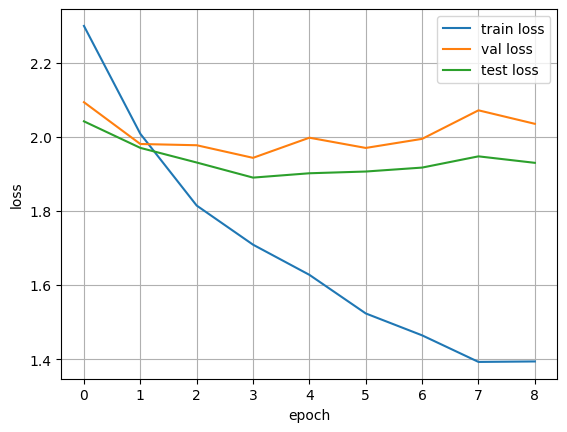

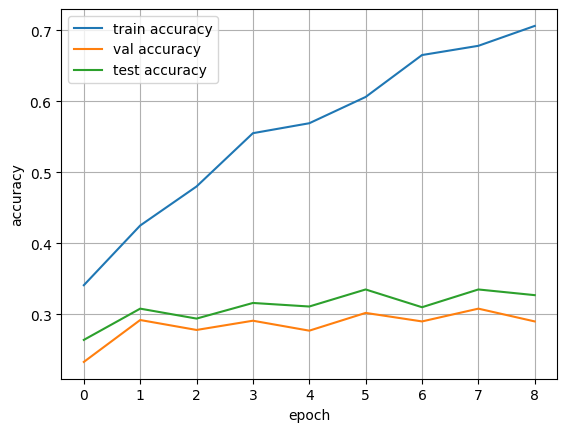

In [76]:
show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val)

plt.figure()  
show_accuracy_through_epochs(arr_acc_train, arr_acc_test, arr_acc_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7502832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24214405..1.6369936].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.4828431..1.2477095].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.3791421..1.8025708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44764107..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.49901

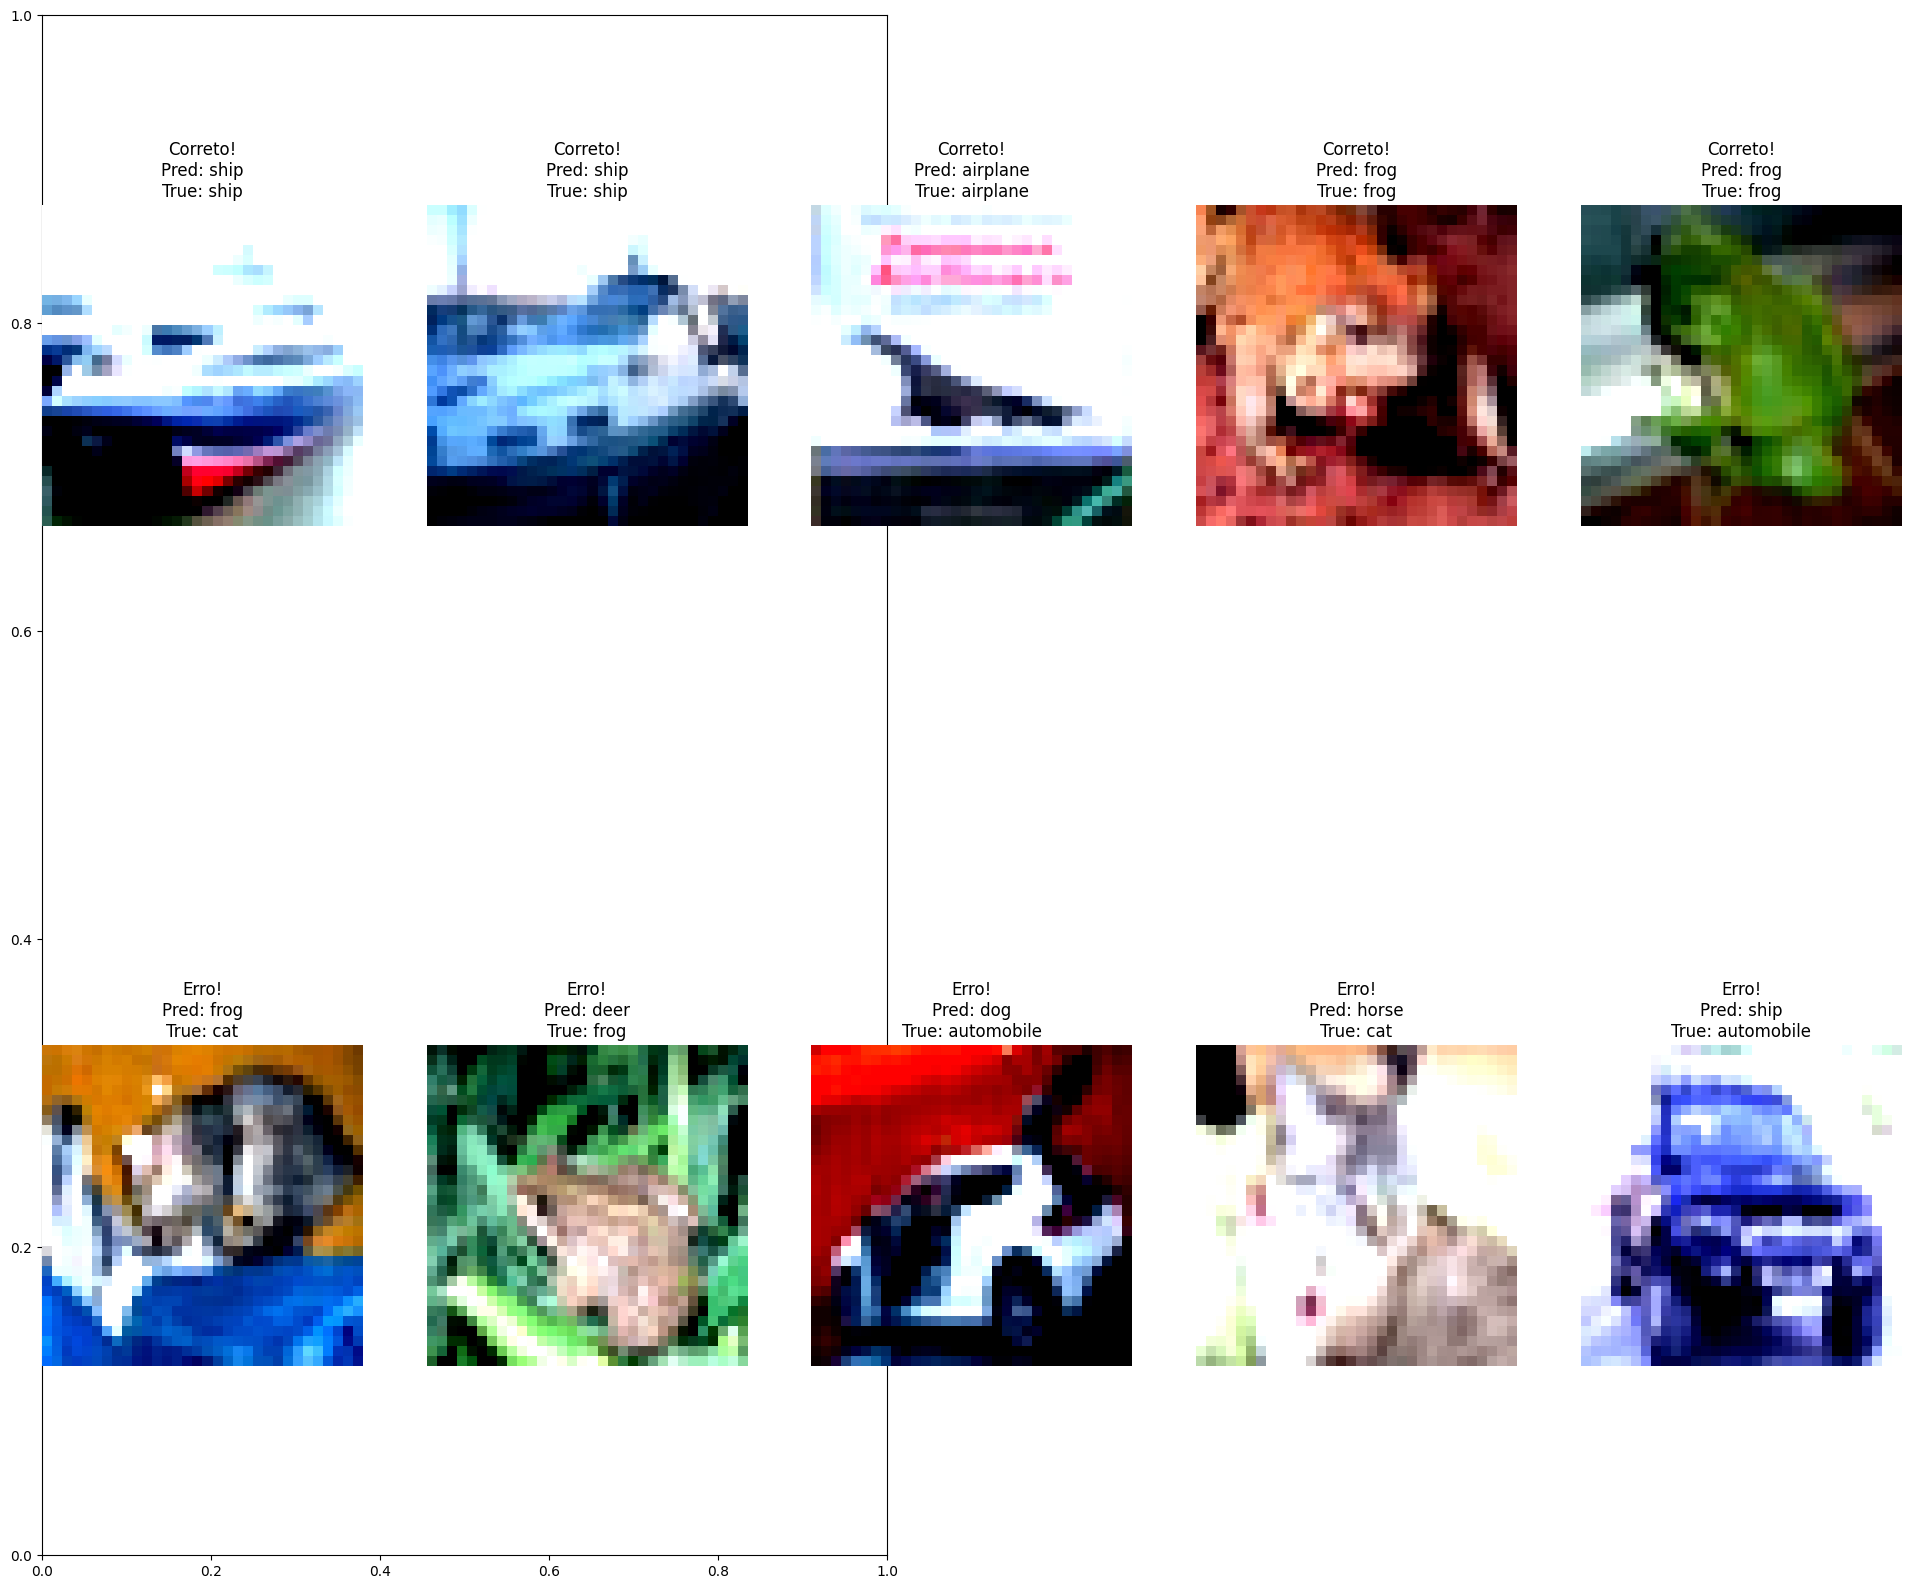

In [77]:
show_predictions(mlp, test_loader, num_samples=5)

In [78]:
mlp.eval()
predictions = []
labels = []

for images, label in test_loader:
  images = images.view(-1,32*32*3).cuda()
  label = label.cuda()

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print(f"Scores of your model\n {scores}\n\n")

Scores of your model
 {'accuracy': 0.327, 'balanced_accuracy': np.float64(0.321024941667298), 'f1_score': 0.3170819868928322, 'precision': 0.32476756086809067, 'recall': 0.327}




In [79]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck'] # .venvNN/lib/python3.12/site-packages/torchvision/prototype/datasets/_builtin/cifar10.categories

labels = np.array(labels)
predictions = np.array(predictions)

stats = {}

print(f"\n shape dataset teste -> {len(test_dataset)}")
print("\n(repr x acc top1) por classe(conjunto teste):")

for i in range(10):
    mask = labels == i
    class_acc = np.mean(predictions[mask] == labels[mask]) * 100
    num_samples = np.sum(mask)
    class_repr = (num_samples / len(labels)) * 100

    stats[classes[i]] = {
        'acuracia': f"{class_acc:.2f}%",
        'num_amostras': num_samples,
        'representatividade': f"{class_repr:.2f}%"
    }

for classe, metricas in stats.items():
    print(f"\n{classe}:")
    print(f"  Acurácia: {metricas['acuracia']}")
    print(f"  Número de amostras: {metricas['num_amostras']}")
    print(f"  Representatividade: {metricas['representatividade']}")


 shape dataset teste -> 1000

(repr x acc top1) por classe(conjunto teste):

airplane:
  Acurácia: 50.49%
  Número de amostras: 103
  Representatividade: 10.30%

automobile:
  Acurácia: 32.58%
  Número de amostras: 89
  Representatividade: 8.90%

bird:
  Acurácia: 13.00%
  Número de amostras: 100
  Representatividade: 10.00%

cat:
  Acurácia: 23.30%
  Número de amostras: 103
  Representatividade: 10.30%

deer:
  Acurácia: 10.00%
  Número de amostras: 90
  Representatividade: 9.00%

dog:
  Acurácia: 26.74%
  Número de amostras: 86
  Representatividade: 8.60%

frog:
  Acurácia: 41.96%
  Número de amostras: 112
  Representatividade: 11.20%

horse:
  Acurácia: 36.27%
  Número de amostras: 102
  Representatividade: 10.20%

ship:
  Acurácia: 49.06%
  Número de amostras: 106
  Representatividade: 10.60%

truck:
  Acurácia: 37.61%
  Número de amostras: 109
  Representatividade: 10.90%


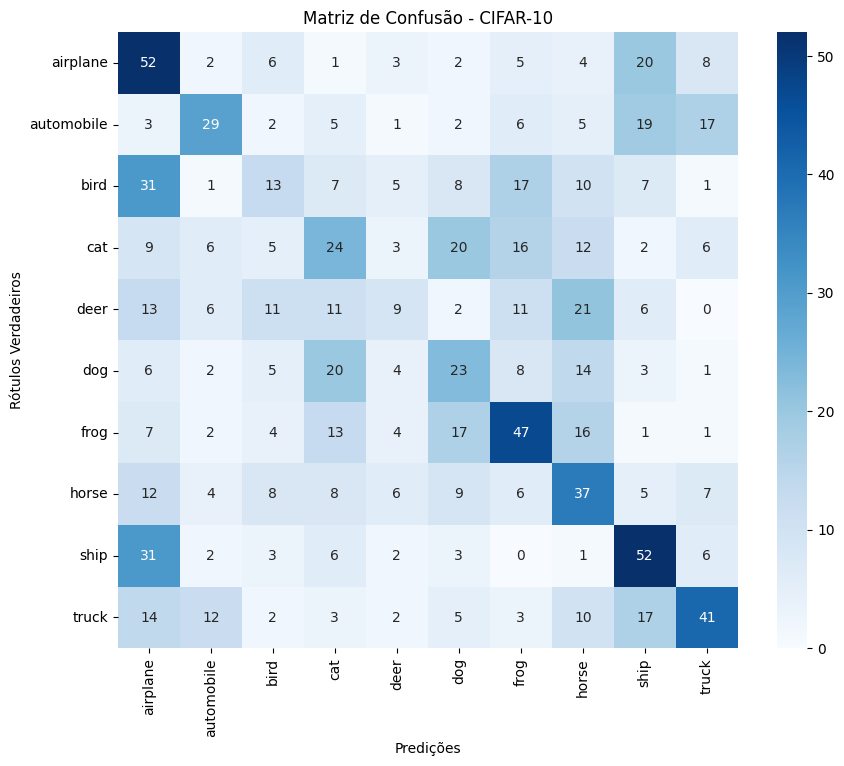

TRUE -> PRED
1. ship → airplane: 31 vezes
2. bird → airplane: 31 vezes
3. deer → horse: 21 vezes
4. cat → dog: 20 vezes
5. dog → cat: 20 vezes


In [80]:
cm = metrics.confusion_matrix(labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Matriz de Confusão - CIFAR-10')
plt.xlabel('Predições')
plt.ylabel('Rótulos Verdadeiros')
plt.show()

cm_errors = cm.copy()
np.fill_diagonal(cm_errors, 0)

flat_indices = np.argsort(cm_errors.ravel())[::-1][:5]
confusion_indices = np.unravel_index(flat_indices, cm_errors.shape)

print(f"TRUE -> PRED")
for i in range(5):
    true_class = confusion_indices[0][i]
    pred_class = confusion_indices[1][i]
    count = cm_errors[true_class, pred_class]
    if count > 0:
        print(f"{i+1}. {classes[true_class]} → {classes[pred_class]}: {count} vezes")